In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
data = pd.read_csv("data.csv")

## Question 1
### a)
Looking briefly at the data, we can see a column total_items, which seems to indicate the total number of purchases made for a given order. If we have multiple items in an order, it makes sense then that the naively calculated average be much higher than the average item price. We double check this assumption below.

In [2]:
data[["order_amount", "total_items"]].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


As indicated above, the mentioned amount of $3145.13 is the simple mean of the order_amount column, and we can see that there are often more than one items in a given order. We also note the very large variance in the data in both order_amount and total_items. To deal with this, we have a few options to better evaluate the data: 1) use the median instead of the mean, 2) finding the average price of an item instead of an order 3) plotting the distribution of AOV

##### Median Order Value
The median is better suited to this dataset given its large variance. As we can see below, it's a much more reasonable number. If the goal is to produce a single number as a metric which best describes the average order value, this would be the best alternative.

In [3]:
data["order_amount"].median()

284.0

##### Average Item Price
We calculate the average price of each item sold to be $357.92. Note that this measures something slightly different than the AOV. This is the average price of an item that sold from one of the 100 stores, while AOV is the average amount a customer spends at the 100 stores. 

In [4]:
data["order_amount"].mean() / data["total_items"].mean()

357.92152221412965

##### AOV Distribution
While not exactly a single metric, we can use a histogram to show how the AOV is distributed. This evaluation would better describe customer tendencies as a whole. As we can see below, the data is heavily left-skewed. Further investigation reveals that even above a more conservative line of $1000, there are only 71 orders. 

<AxesSubplot:>

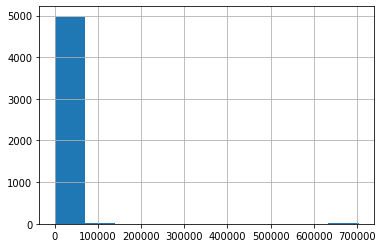

In [5]:
data["order_amount"].hist()

In [6]:
data["order_amount"][data["order_amount"] >= 1000].count(), data["order_amount"][data["order_amount"] >= 700000].count()

(71, 17)

### b) & c)
If we're looking for a single metric, I would use the median order amount. Median order amount does the best job of describing the behavior of the average customer in the given reporting period. It is the simplest way to describe the average customer's spending habits in Shopify sneaker stores. It has further value from its ability to be easily compared with the same metric in other reporting periods to identify trends. However using more information could give more actionable insights. For instance, we could look at how the order amount varies with shop_id, payment_method, or the item price. Examples shown below (note the logarithmic axes):

<AxesSubplot:title={'center':'Order Amount by Shop'}, xlabel='order_amount', ylabel='shop_id'>

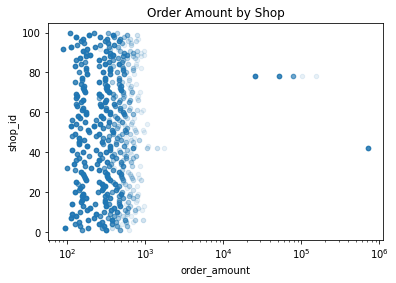

In [7]:
data.plot.scatter(x="order_amount", y="shop_id", alpha=0.1, title="Order Amount by Shop", logx=True)

<AxesSubplot:title={'center':'Order Amount by Payment Method'}, xlabel='order_amount', ylabel='payment_method'>

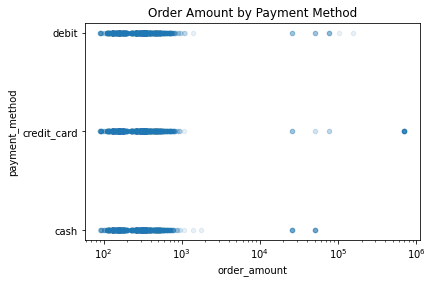

In [8]:
data.plot.scatter(x="order_amount", y="payment_method", alpha=0.1, title="Order Amount by Payment Method", logx=True)

<AxesSubplot:title={'center':'Order Amount by Item Price'}, xlabel='order_amount', ylabel='item_price'>

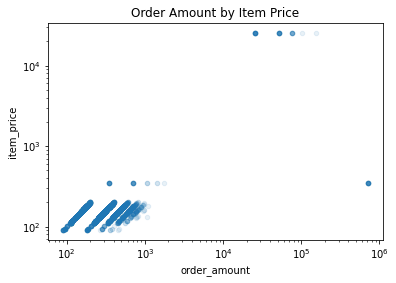

In [9]:
data["item_price"] = data["order_amount"] / data["total_items"]
data.plot.scatter(x="order_amount", y="item_price", alpha=0.1, title="Order Amount by Item Price", logx=True, logy=True)

From that quick analysis, we can see that a only a handful of stores are responsible for the high value orders, that credit and debit are slightly more common for high value orders, and that average order values rise with the item price (indicating that customers are generally not driven away from higher individual prices). If our business objective was to maximize high value orders, we could consider bringing on more high-priced items, for example. However, these are not exactly metrics that can easily be compared from one reporting period to another and so using median order value might be better suited to the given business case.

## Question 2

### a)
How many orders were shipped by Speedy Express in total?
```
SELECT count(*) FROM Orders;

196
```
### b)
What is the last name of the employee with the most orders?
```
SELECT LastName 
FROM Employees 
WHERE EmployeeID = 
    (SELECT EmployeeID
    FROM 
        (SELECT EmployeeID, COUNT(*) as OrderCount
         FROM ORDERS
         GROUP BY EmployeeID)
    WHERE OrderCount = (SELECT Max(OrderCount)
                        FROM 
                          (SELECT EmployeeID, COUNT(*) as OrderCount
                          FROM ORDERS
                          GROUP BY EmployeeID)));
                          
Peacock
```
### c)
What product was ordered the most by customers in Germany?
```
SELECT a.ProductName
FROM
    (SELECT od.ProductID, SUM(od.Quantity) as ProdQuantity
    FROM Orders o
    INNER JOIN Customers c
    ON o.CustomerID = c.CustomerID
    INNER JOIN OrderDetails od
    ON o.OrderID = od.OrderID
    WHERE c.Country = "Germany"
    GROUP BY od.ProductID) b
INNER JOIN Products a
ON a.ProductID = b.ProductID
WHERE ProdQuantity = 
	(SELECT MAX(ProdQuantity)
    FROM 
    	(SELECT od.ProductID, SUM(od.Quantity) as ProdQuantity
        FROM Orders o
        INNER JOIN Customers c
        ON o.CustomerID = c.CustomerID
        INNER JOIN OrderDetails od
        ON o.OrderID = od.OrderID
        WHERE c.Country = "Germany"
        GROUP BY od.ProductID))

Boston Crab Meat
```